## Detector de Spam com Rede Neural Recorrente
Diego Hartwig - 2024

Importação das bibliotecas

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

Carregando a base de dados

In [2]:
!wget http://www.razer.net.br/datasets/spam.csv

df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()

df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df.columns = ['labels', 'data']
df["b_labels"] = df["labels"].map({"ham": 0, "spam": 1})
y = df["b_labels"].values
df.head()

--2024-07-29 17:58:03--  http://www.razer.net.br/datasets/spam.csv
Resolving www.razer.net.br (www.razer.net.br)... 178.128.150.229
Connecting to www.razer.net.br (www.razer.net.br)|178.128.150.229|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  1.60MB/s    in 0.3s    

2024-07-29 17:58:03 (1.60 MB/s) - ‘spam.csv’ saved [503663/503663]



,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


# Separação em Treino e Teste

In [3]:
x_train, x_test, y_train, y_test = train_test_split(df["data"], y, test_size=0.33)

# Tokenização

In [5]:
num_words = 20000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
word2index = tokenizer.word_index
V = len(word2index)
print("%s Tokens" % V)

7146 Tokens


# Tamanho das sequencias - padding

In [7]:
data_train = pad_sequences(sequences_train)
T = data_train.shape[1]
print("Tamanho das sequencias: %s" % T)

data_test = pad_sequences(sequences_test, maxlen=T)
print("data_train.shape = ", data_train.shape)
print("data_test.shape = ", data_test.shape)

Tamanho das sequencias: 162
data_train.shape =  (3733, 162)
data_test.shape =  (1839, 162)


# Definindo o modelo

In [8]:
D = 20
M = 5

i = Input(shape=(T, ))
x = Embedding(V + 1, D)(i)
x = LSTM(M)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(i, x)

# Exibindo o modelo

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 162)]             0         
                                                                 
 embedding (Embedding)       (None, 162, 20)           142940    
                                                                 
 lstm (LSTM)                 (None, 5)                 520       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 143466 (560.41 KB)
Trainable params: 143466 (560.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Compilando e Treinando o modelo

In [10]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

epochs = 5

r = model.fit(
    data_train, y_train,
    validation_data=(data_test, y_test),
    epochs=epochs
)

Epoch 1/5
117/117 [==============================] - 18s 123ms/step - loss: 0.5074 - accuracy: 0.8567 - val_loss: 0.2779 - val_accuracy: 0.8722
Epoch 2/5
117/117 [==============================] - 7s 63ms/step - loss: 0.1810 - accuracy: 0.9387 - val_loss: 0.1412 - val_accuracy: 0.9690
Epoch 3/5
117/117 [==============================] - 4s 35ms/step - loss: 0.1126 - accuracy: 0.9826 - val_loss: 0.1092 - val_accuracy: 0.9788
Epoch 4/5
117/117 [==============================] - 4s 37ms/step - loss: 0.0785 - accuracy: 0.9901 - val_loss: 0.0879 - val_accuracy: 0.9826
Epoch 5/5
117/117 [==============================] - 3s 25ms/step - loss: 0.0641 - accuracy: 0.9949 - val_loss: 0.0831 - val_accuracy: 0.9826


# Plotando função de perda e acurácia

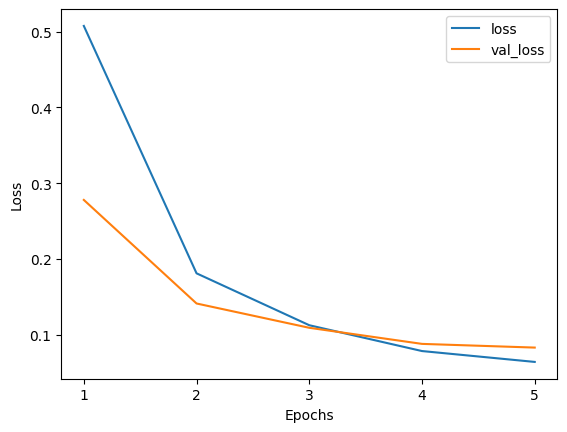

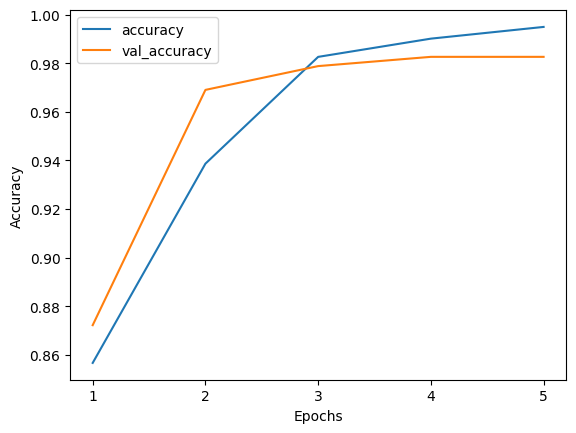

In [11]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0, epochs, step=1), labels=range(1, epochs+1))
plt.legend()
plt.show()

plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0, epochs, step=1), labels=range(1, epochs+1))
plt.legend()
plt.show()

# Predição de um novo texto

In [15]:
texto = "UNBELIEVABLE OFFER!!! Hello! You have been selected to receive an EXCLUSIVE 70% discount on all our electronic products. Don't miss this unique opportunity! Click the link below to take advantage before it's gone![SuperDiscountElectronics.com]Offer valid for a limited time only!!! "

seq_texto = tokenizer.texts_to_sequences([texto])
data_texto = pad_sequences(seq_texto, maxlen=T)

pred = model.predict(data_texto)
print(pred)
print("SPAM" if pred >= 0.5 else "OK")

1/1 [==============================] - 0s 19ms/step
[[0.6285077]]
SPAM
